# Reinplementation of Block Coordinate Descent (BCD) Algorithm for Training DNNs (3-layer MLP) for MNIST in PyTorch

## Import libraries

In [1]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50; 
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.1.0
Torchvision Version: 0.2.2
GPU is available? True


## Read in MNIST dataset

In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert to tensor and scale to [0, 1]
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

9920512it [00:00, 9999488.89it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 112308.93it/s]           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1771405.76it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 40364.86it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Data manipulation

In [3]:
# Manipulate train set
x_d0 = mnist_trainset[0][0].size()[0]
x_d1 = mnist_trainset[0][0].size()[1]
x_d2 = mnist_trainset[0][0].size()[2]
N = x_d3 = len(mnist_trainset)
K = 10
x_train = torch.empty((N,x_d0*x_d1*x_d2), device=device)
y_train = torch.empty(N, dtype=torch.long)
for i in range(N): 
     x_train[i,:] = torch.reshape(mnist_trainset[i][0], (1, x_d0*x_d1*x_d2))
     y_train[i] = mnist_trainset[i][1]
x_train = torch.t(x_train)
y_one_hot = torch.zeros(N, K).scatter_(1, torch.reshape(y_train, (N, 1)), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)
y_train = y_train.to(device=device)

# Manipulate test set
N_test = x_d3_test = len(mnist_testset)
x_test = torch.empty((N_test,x_d0*x_d1*x_d2), device=device)
y_test = torch.empty(N_test, dtype=torch.long)
for i in range(N_test): 
     x_test[i,:] = torch.reshape(mnist_testset[i][0], (1, x_d0*x_d1*x_d2))
     y_test[i] = mnist_testset[i][1]
x_test = torch.t(x_test)
y_test_one_hot = torch.zeros(N_test, K).scatter_(1, torch.reshape(y_test, (N_test, 1)), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)
y_test = y_test.to(device=device)

## Main algorithm (Jinshan's Algorithm in Zeng et al (2018))

### Parameter initialization

In [4]:
seed = 40
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.manual_seed(seed)
d0 = x_d0*x_d1*x_d2
d1 = d2 = d3 = 1500
d4 = K # Layers: input + 3 hidden + output
W1 = 0.01*torch.randn(d1, d0, device=device)
b1 = 0.1*torch.ones(d1, 1, device=device)
W2 = 0.01*torch.randn(d2, d1, device=device)
b2 = 0.1*torch.ones(d2, 1, device=device)
W3 = 0.01*torch.randn(d3, d2, device=device)
b3 = 0.1*torch.ones(d3, 1, device=device)
W4 = 0.01*torch.randn(d4, d3, device=device)
b4 = 0.1*torch.ones(d4, 1, device=device)

U1 = torch.addmm(b1.repeat(1, N), W1, x_train)
V1 = nn.ReLU()(U1)
U2 = torch.addmm(b2.repeat(1, N), W2, V1)
V2 = nn.ReLU()(U2)
U3 = torch.addmm(b3.repeat(1, N), W3, V2)
V3 = nn.ReLU()(U3) 
U4 = torch.addmm(b4.repeat(1, N), W4, V3)
V4 = U4

gamma = 1
gamma1 = gamma2 = gamma3 = gamma4 = gamma

rho = 1
rho1 = rho2 = rho3 = rho4 = rho


alpha = 5
alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
= alpha8 = alpha9 = alpha10 = alpha

niter = 50
loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)

### Define functions for updating blocks

In [5]:
def updateV(U1,U2,W,b,rho,gamma): 
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [6]:
def updateWb(U, V, W, b, alpha, rho): 
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = (alpha*b+rho*torch.sum(U-torch.mm(W,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [7]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Training algorithm

In [8]:
# Iterations
print('Train on', N, 'samples, validate on', N_test, 'samples')
for k in range(niter):
    start = time.time()

    # update V4
    V4 = (y_one_hot + gamma4*U4 + alpha1*V4)/(1 + gamma4 + alpha1)
    
    # update U4 
    U4 = (gamma4*V4 + rho4*(torch.mm(W4,V3) + b4.repeat(1,N)))/(gamma4 + rho4)

    # update W4 and b4
    W4, b4 = updateWb(U4,V3,W4,b4,alpha2,rho4)
    
    # update V3
    V3 = updateV(U3,U4,W4,b4,rho4,gamma3)
    
    # update U3
    U3 = relu_prox(V3,(rho3*torch.addmm(b3.repeat(1,N), W3, V2) + alpha3*U3)/(rho3 + alpha3),(rho3 + alpha3)/gamma3,d3,N)
    
    # update W3 and b3
    W3, b3 = updateWb(U3,V2,W3,b3,alpha4,rho3)
    
    # update V2
    V2 = updateV(U2,U3,W3,b3,rho3,gamma2)
    
    # update U2
    U2 = relu_prox(V2,(rho2*torch.addmm(b2.repeat(1,N), W2, V1) + alpha5*U2)/(rho2 + alpha5),(rho2 + alpha5)/gamma2,d2,N)
    
    # update W2 and b2
    W2, b2 = updateWb(U2,V1,W2,b2,alpha6,rho2)

    # update V1
    V1 = updateV(U1,U2,W2,b2,rho2,gamma1)
    
    # update U1
    U1 = relu_prox(V1,(rho1*torch.addmm(b1.repeat(1,N), W1, x_train) + alpha7*U1)/(rho1 + alpha7),(rho1 + alpha7)/gamma1,d1,N)

    # update W1 and b1
    W1, b1 = updateWb(U1,x_train,W1,b1,alpha8,rho1)

    a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1, x_train))
    a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N), W2, a1_train))
    a3_train = nn.ReLU()(torch.addmm(b3.repeat(1, N), W3, a2_train))
    #print(torch.addmm(b4.repeat(1, N), W4, a3_train))
    pred = torch.argmax(torch.addmm(b4.repeat(1, N), W4, a3_train), dim=0)

    a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1, x_test))
    a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test), W2, a1_test))
    a3_test = nn.ReLU()(torch.addmm(b3.repeat(1, N_test), W3, a2_test))
    pred_test = torch.argmax(torch.addmm(b4.repeat(1, N_test), W4, a3_test), dim=0)
    
    loss1[k] = gamma4/2*torch.pow(torch.dist(V4,y_one_hot,2),2).cpu().numpy()
    loss2[k] = loss1[k] + rho1/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1, x_train),U1,2),2).cpu().numpy() \
    +rho2/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N), W2, V1),U2,2),2).cpu().numpy() \
    +rho3/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy() \
    +rho4/2*torch.pow(torch.dist(torch.addmm(b4.repeat(1,N), W4, V3),U4,2),2).cpu().numpy()
    
    # compute training accuracy
    correct_train = pred == y_train
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
    
    # compute validation accuracy
    correct_test = pred_test == y_test
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
    
    # compute training time
    stop = time.time()
    duration = stop - start
    time1[k] = duration
    
    # print results
    print('Epoch', k + 1, '/', niter, '\n', 
          '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k], 
          '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k])

Train on 60000 samples, validate on 10000 samples
Epoch 1 / 50 
 - time: 3.443815231323242 - sq_loss: 20286.423828125 - tot_loss: 20314.91462197248 - acc: 0.13435 - val_acc: 0.1326
Epoch 2 / 50 
 - time: 1.8649756908416748 - sq_loss: 15321.1953125 - tot_loss: 15332.77514443826 - acc: 0.7184333333333334 - val_acc: 0.7266
Epoch 3 / 50 
 - time: 1.875713586807251 - sq_loss: 11774.9140625 - tot_loss: 11782.538913727738 - acc: 0.8724 - val_acc: 0.8773
Epoch 4 / 50 
 - time: 1.8710741996765137 - sq_loss: 9107.599609375 - tot_loss: 9114.262744601816 - acc: 0.9029833333333334 - val_acc: 0.9074
Epoch 5 / 50 
 - time: 1.882650375366211 - sq_loss: 7059.7607421875 - tot_loss: 7066.023923350498 - acc: 0.91305 - val_acc: 0.9137
Epoch 6 / 50 
 - time: 1.8721821308135986 - sq_loss: 5475.943359375 - tot_loss: 5482.097131313756 - acc: 0.9198666666666667 - val_acc: 0.9197
Epoch 7 / 50 
 - time: 1.8659634590148926 - sq_loss: 4247.96533203125 - tot_loss: 4253.651355717331 - acc: 0.9241 - val_acc: 0.9236
Ep

### Visualization of training results

Text(0.5,1,'accuracy')

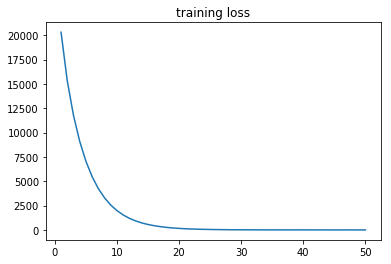

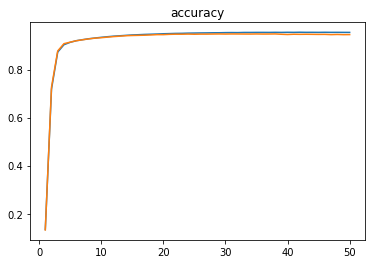

In [9]:
plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train)
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('accuracy')